In [1]:
import warnings
warnings.filterwarnings('ignore')
from utils import future, continuous_future, history, bundle_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from strategies.contracts import contracts

In [3]:
con = [continuous_future(contract,
                          offset=0,
                          adjustment='mul',
                          roll_style='volume')
        for contract in contracts]

In [4]:
his = history(assets=con, 
              end_dt=pd.Timestamp('2018-10-31', tz='UTC'),
              bar_count=252,
              frequency='1d',
              field='price',
              data_frequency='daily'
             )
his.columns = his.columns.map(lambda x: x.root_symbol)

In [5]:
returns = np.log(his.pct_change()+1)[1:]

In [6]:
corr = returns.corr()

In [7]:
# quick sanity check
print('S&P vs NAS: ', corr.loc['ES', 'NQ'])
print('S&P vs. oil: ', corr.loc['ES', 'CL'])
print('Treasuries vs. Fed Funds: ', corr.loc['US', 'FF'])
print('Gold vs. Eurodollar:', corr.loc['GC', 'ED'])
print('Gold vs. Treasuries:', corr.loc['GC', 'US'])

S&P vs NAS:  0.9189347744642006
S&P vs. oil:  0.28267705770351625
Treasuries vs. Fed Funds:  0.25192935996977184
Gold vs. Eurodollar: -0.034512996936981705
Gold vs. Treasuries: 0.21373695980633695


In [8]:
# pull out sector data from sqlite
import sqlalchemy as sa
d = bundle_data.asset_finder.futures_root_symbols.c
def get_sector(root_symbol):
    fields = (d.sector,)
    sector = sa.select(fields).where(
            d.root_symbol == root_symbol).execute().scalar()
    return sector.split('/')
def get_name(root_symbol):
    fields = (d.description,)
    name = sa.select(fields).where(
            d.root_symbol == root_symbol).execute().scalar()
    return name

In [9]:
get_sector('ES')

['Equities', 'US Index']

In [10]:
get_name('ES')

'E-mini S&P 500 Futures'

# Contract Reference List 

In [11]:
sect_dict = {symbol: get_sector(symbol) for symbol in contracts}
sectors = pd.DataFrame(sect_dict).T
sectors.columns = ['sector', 'sub-sector']
sectors['name'] = sectors.index.map(get_name)
sectors

,sector,sub-sector,name
AD,FX,Majors,Australian Dollar Futures
BO,Agriculture,Grain And Oilseed,Soybean Oil Futures
BP,FX,Majors,British Pound Futures
BZ,Energy,Crude Oil,Brent Crude Oil Financial Futures
CD,FX,Majors,Canadian Dollar Futures
CL,Energy,Crude Oil,Crude Oil Futures
DA,Agriculture,Dairy,Class III Milk Futures
EC,FX,Majors,Euro FX Futures
ED,Interest Rate,Stir,Eurodollar Futures
EH,Energy,Ethanol,Ethanol Futures


In [12]:
sns.set_style('whitegrid')
#colormap = sns.diverging_palette(220, 10, as_cmap=True)
colormap = sns.diverging_palette(133, 10, n=5, as_cmap=True)

# Single Contract Correlation by Sector

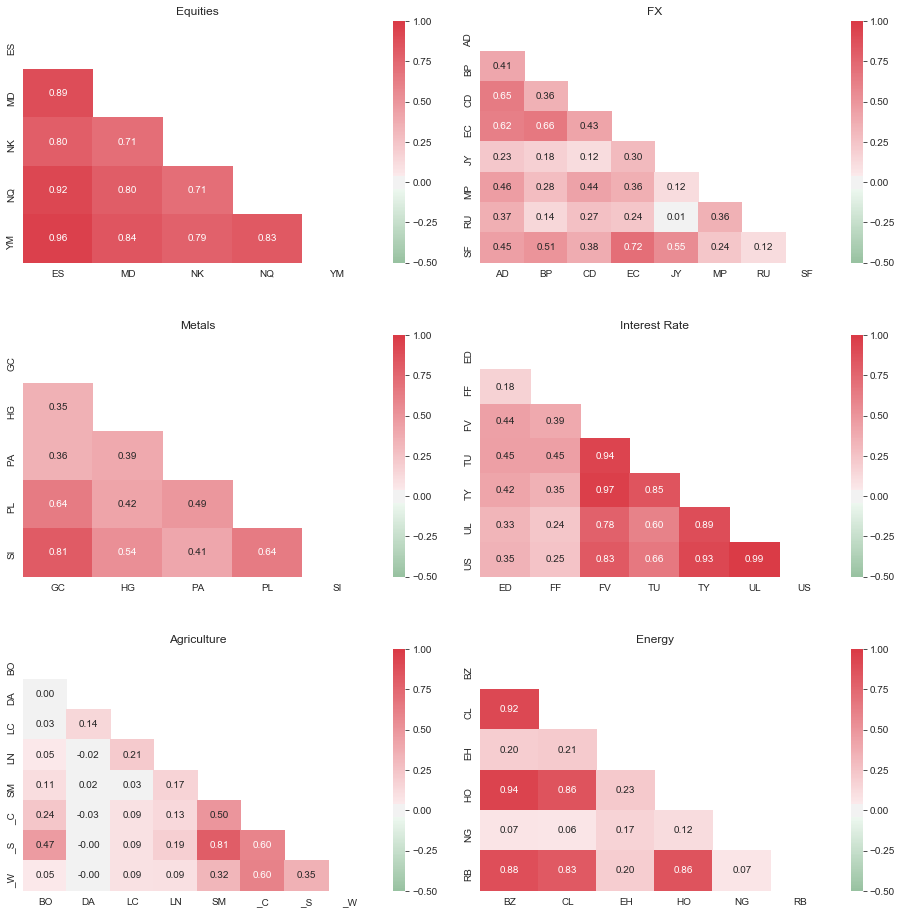

In [13]:
corr_by_sector = {}
for sector, symbols in sectors.groupby('sector').groups.items():
    corr_by_sector[sector] = returns[symbols].corr()

fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=.3, wspace=.05)
rows = np.ceil(len(corr_by_sector.keys())/2)
index = 0
for sector, table in corr_by_sector.items():
    index += 1
    dropSelf = np.zeros_like(table)
    dropSelf[np.triu_indices_from(dropSelf)] = True
    ax = fig.add_subplot(rows, 2, index)
    sns.heatmap(table, cmap=colormap, annot=True, fmt=".2f", 
                vmin=-.5, vmax=1, center=0, mask=dropSelf, ax=ax).set_title(sector);

# Single Contract Correlation by Sub-sector

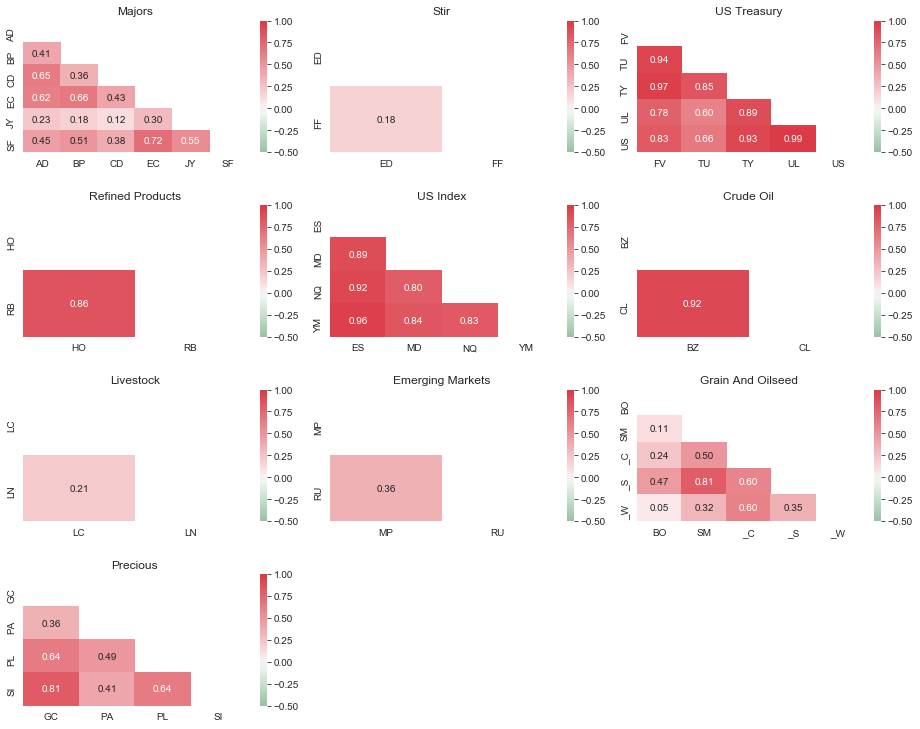

In [14]:
corr_by_sub_sector = {}
for sector, symbols in sectors.groupby('sub-sector').groups.items():
    corr_by_sub_sector[sector] = returns[symbols].corr()

fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=.4, wspace=.1)
rows = np.ceil(len(corr_by_sub_sector.keys())/3)
index = 0
for sector, table in corr_by_sub_sector.items():
    if table.shape == (1,1):
        continue
    index += 1
    dropSelf = np.zeros_like(table)
    dropSelf[np.triu_indices_from(dropSelf)] = True
    ax = fig.add_subplot(rows, 3, index)
    sns.heatmap(table, cmap=colormap, annot=True, fmt=".2f", 
                vmin=-.5, vmax=1, center=0, mask=dropSelf, ax=ax).set_title(sector);

# Sector Indices Correlation

In [15]:
sector_index = pd.DataFrame()
for sector, symbols in sectors.groupby('sector').groups.items():
    df = his[symbols].copy()
    df= df.pct_change()[1:]
    ind = df.apply(lambda x: np.average(x), axis=1)
    sector_index[sector] = ind

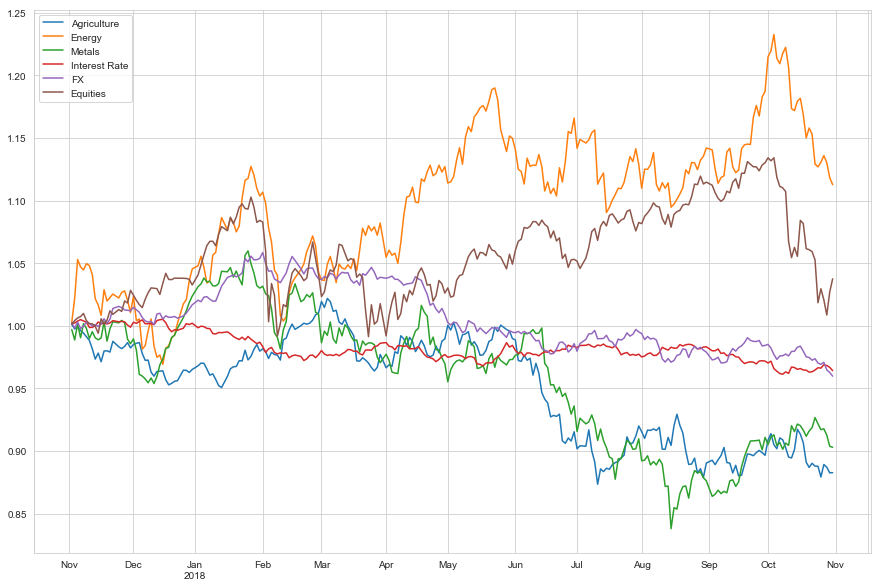

In [16]:
(sector_index + 1).cumprod().plot(grid=True, figsize=(15,10));

In [17]:
sector_returns = np.log(sector_index + 1)

In [18]:
sector_corr = sector_returns.corr()

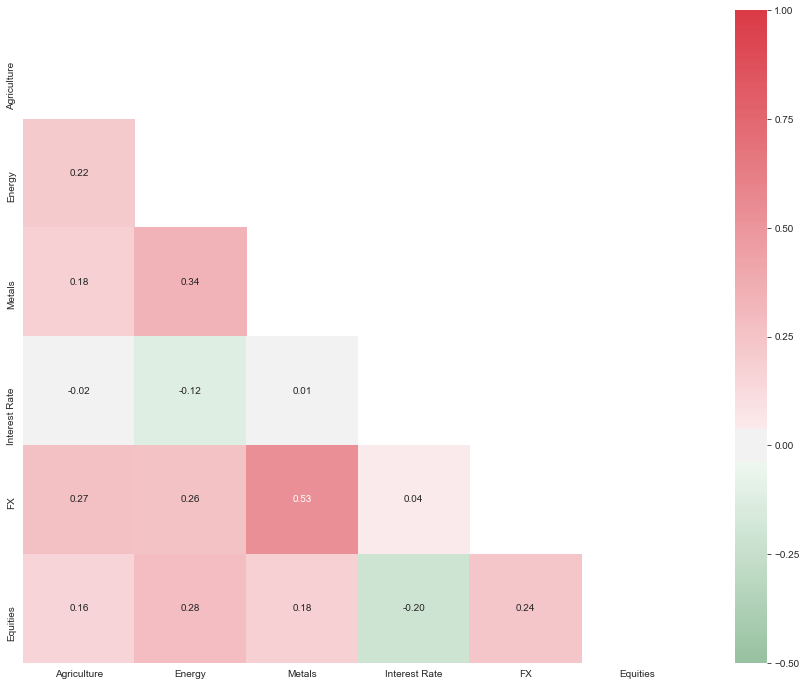

In [19]:
plt.figure(figsize=(15,12))
dropSelf = np.zeros_like(sector_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(sector_corr, cmap=colormap, annot=True, fmt=".2f", vmin=-.5, vmax=1, center=0, mask=dropSelf);

# Sub-sector Indices Correlation

In [20]:
sub_sector_index = pd.DataFrame()
for sector, symbols in sectors.groupby('sub-sector').groups.items():
    df = his[symbols].copy()
    df=df.pct_change()[1:]
    ind = df.apply(lambda x: np.average(x), axis=1)
    sub_sector_index[sector] = ind

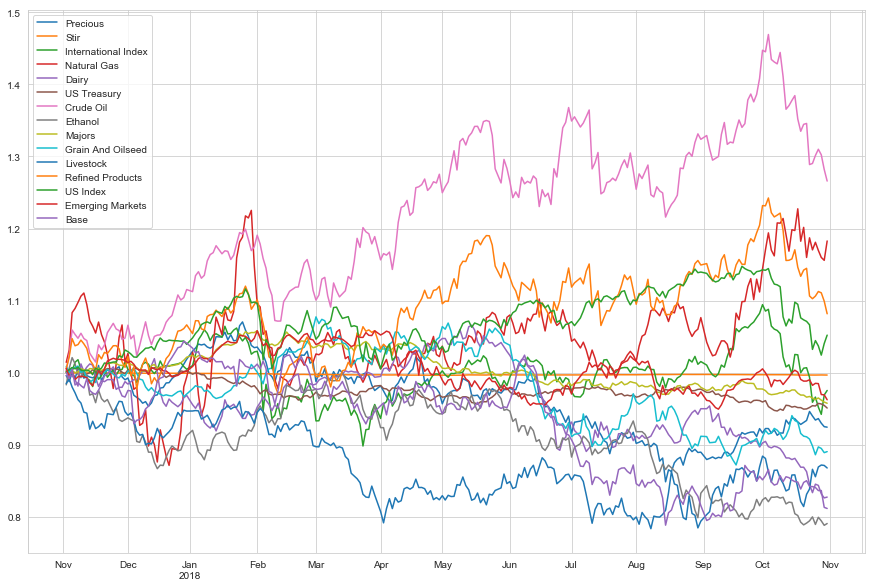

In [21]:
(sub_sector_index + 1).cumprod().plot(grid=True, figsize=(15,10));

In [22]:
sub_sector_returns = np.log(sub_sector_index + 1)

In [23]:
sub_sector_corr = sub_sector_returns.corr()

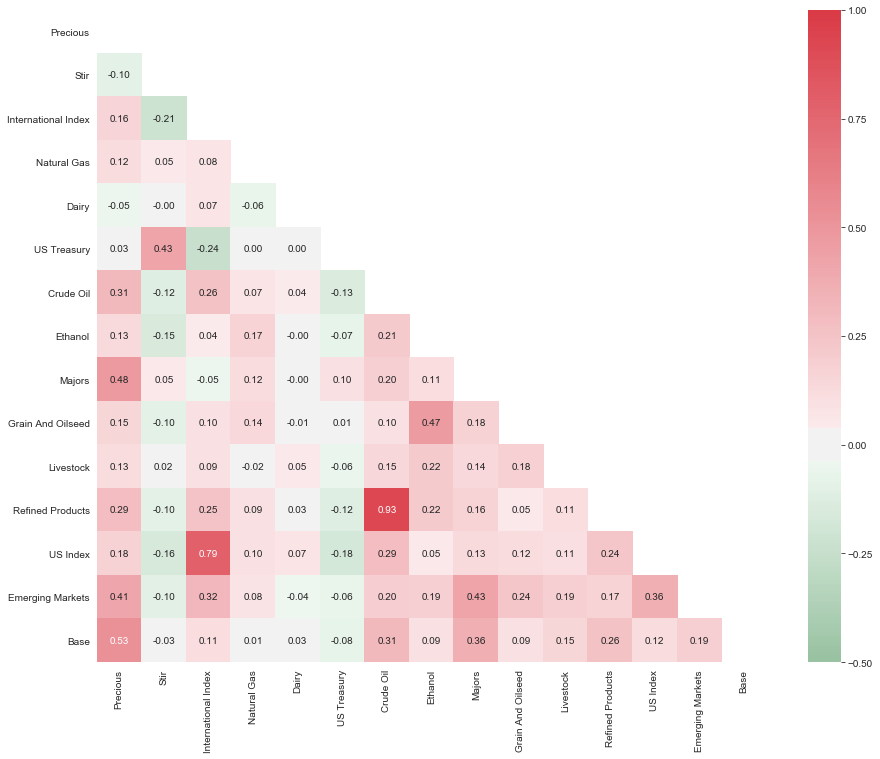

In [24]:
plt.figure(figsize=(15,12))
dropSelf = np.zeros_like(sub_sector_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(sub_sector_corr, cmap=colormap, annot=True, fmt=".2f", vmin=-.5, vmax=1, center=0, mask=dropSelf);

# Correlation Stability Over Time

In [25]:
periods = 2520 * 2 # about 20 years
long_history = history(assets=con, 
                       end_dt=pd.Timestamp('2018-10-31', tz='UTC'),
                       bar_count=periods,
                       frequency='1d',
                       field='price',
                       data_frequency='daily'
                      )
long_history.columns = long_history.columns.map(lambda x: x.root_symbol)

In [26]:
sample = ['ES', 'TY', 'CL', 'GC',] # up to 4 to make number of charts reasonable

In [27]:
def correlation_history(pair, method='pearson'):
    ret = np.log(long_history[pair].pct_change()+1)[1:]
    correlations = pd.Series()
    for i in range(periods-252):
        period_ret = ret[i: 252+i].copy()
        correlations.set_value(period_ret.index[-1], period_ret.corr(method=method).iloc[0,1])
    return correlations

In [28]:
def get_correlations(method='pearson'):
    corr_dict = {}
    for item in sample:
        for other in sample:
            if item == other:
                continue
            key = '{} ({}) vs. {} ({})'.format(item, get_name(item), other, get_name(other))
            corr_dict[key] = correlation_history([item, other], method=method)
    return corr_dict

In [29]:
def draw_charts(corr_dict):
    fig = plt.figure()
    cols = 3
    rows = int(np.ceil(len(corr_dict.keys())/cols))
    fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(17,10))

    index = 0
    for symbol, table in corr_dict.items():
        row = int(index/3)
        col = index % 3
        ax[row, col].plot(table)
        ax[row, col].grid(True)
        ax[row, col].set_title(symbol)
        index += 1

In [30]:
pearson_corr = get_correlations()
spearman_corr = get_correlations('spearman')

Simple correlations

<Figure size 432x288 with 0 Axes>

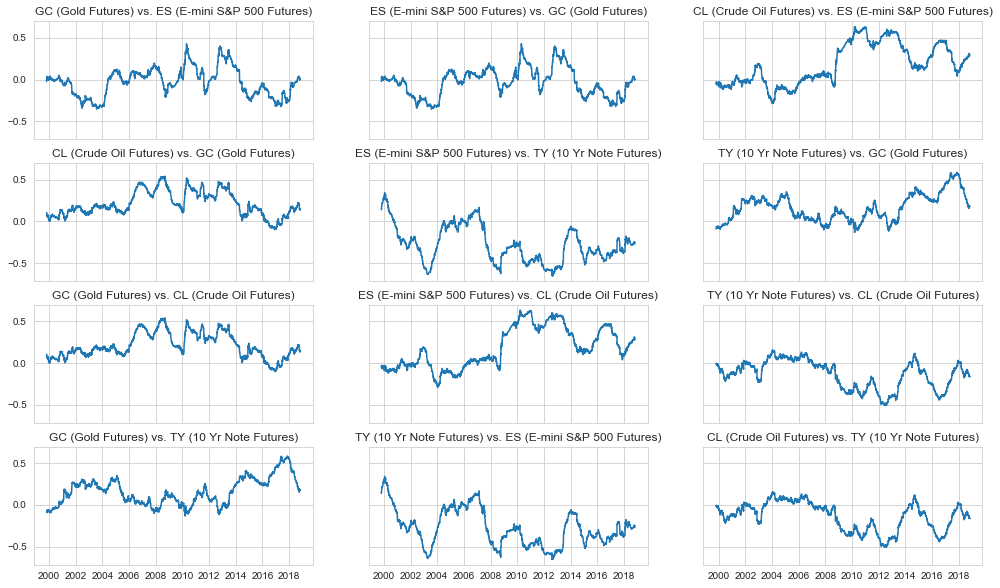

In [31]:
draw_charts(pearson_corr)

Spearman rank correlations

<Figure size 432x288 with 0 Axes>

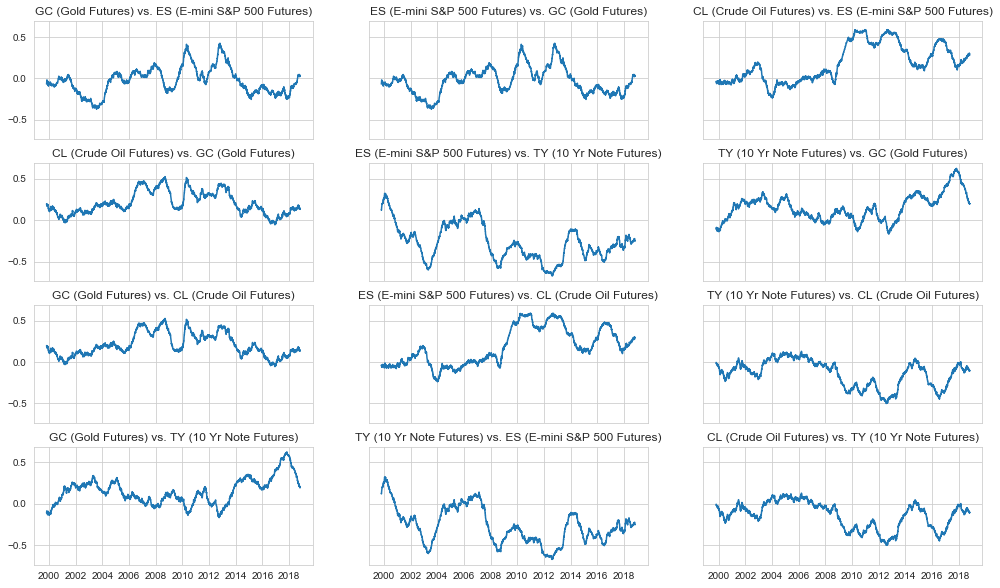

In [32]:
draw_charts(spearman_corr)

# Auto-correlation

In [33]:
returns.apply(lambda x: x.autocorr(25)).sort_values(ascending=False)

CL    0.116589
ED    0.108173
HO    0.103362
BZ    0.088603
LN    0.068331
TU    0.054865
FV    0.045478
RB    0.040560
LC    0.039543
YM    0.038319
NK    0.036526
TY    0.034309
FF    0.033724
HG    0.031665
NQ    0.031344
ES    0.028322
JY    0.020785
_W    0.012735
PL    0.008115
DA    0.003198
MP   -0.000665
RU   -0.001741
SM   -0.009644
SI   -0.010185
GC   -0.018295
PA   -0.021332
UL   -0.029982
US   -0.033133
EH   -0.044764
AD   -0.045994
MD   -0.046537
CD   -0.073011
_C   -0.076850
BO   -0.089870
EC   -0.102347
SF   -0.110547
_S   -0.115749
BP   -0.123837
NG   -0.152694
dtype: float64

Autocorrelations by number of lookaback periods

In [34]:
autocorrs = pd.DataFrame()
for p in range(5, 105, 5):
    autocorrs[p] = returns.apply(lambda x: x.autocorr(p))
autocorrs = autocorrs.T

In [35]:
autocorrs

,ED,TY,FV,TU,US,FF,UL,ES,NQ,YM,...,BO,SM,LC,LN,DA,GC,HG,SI,PL,PA
5,0.034663,0.062593,0.061188,-0.003771,0.025537,-0.033409,0.003991,-0.089641,-0.165068,-0.079411,...,0.046624,-0.002575,-0.024797,0.078247,-0.036500,-0.009831,-0.016008,0.015414,-0.070465,-0.020034
10,-0.019529,-0.016334,-0.014338,-0.071509,-0.005241,-0.089727,0.023743,0.040457,0.084415,0.023468,...,-0.048004,-0.044919,-0.036341,-0.150428,0.121704,-0.131620,-0.075445,-0.154095,-0.075446,-0.131457
15,0.015579,0.029075,0.019392,0.013962,0.004342,0.058164,-0.011427,-0.044090,-0.063864,-0.032183,...,0.054601,0.028878,-0.103132,0.021596,0.032769,0.046091,-0.009072,-0.031837,0.035722,-0.024020
20,0.011313,0.045254,0.060281,0.035440,0.032460,-0.107234,0.033861,-0.054600,-0.042854,-0.074446,...,-0.156593,-0.000513,0.077815,-0.030017,0.116461,0.056676,-0.104083,-0.005378,-0.095456,0.063856
25,0.108173,0.034309,0.045478,0.054865,-0.033133,0.033724,-0.029982,0.028322,0.031344,0.038319,...,-0.089870,-0.009644,0.039543,0.068331,0.003198,-0.018295,0.031665,-0.010185,0.008115,-0.021332
30,0.032850,-0.000242,0.004226,0.042961,0.024211,0.035034,0.057126,0.040218,0.019441,0.001242,...,0.048950,-0.057643,-0.028132,-0.003659,-0.011019,-0.152377,0.030488,-0.074719,0.000912,-0.137178
35,0.016448,0.028719,0.022622,0.007603,0.022301,0.006994,0.001345,0.018548,0.031644,-0.003144,...,-0.050624,-0.042149,-0.052480,0.055281,-0.083146,0.024176,0.119754,-0.024096,0.038333,0.049292
40,-0.006262,0.115049,0.137102,0.114181,0.094199,0.047086,0.086125,0.012455,-0.013765,-0.004760,...,0.123391,0.022332,-0.026303,0.080313,-0.070743,0.001566,0.019375,0.058764,0.090149,0.068577
45,-0.103648,0.005381,0.037371,0.041447,-0.048589,0.023388,-0.052961,0.049120,0.049469,0.032262,...,0.019318,-0.064815,0.028823,0.084980,0.070894,0.009923,0.055946,0.085065,-0.022186,-0.049910
50,0.009600,-0.058863,-0.069383,-0.069290,-0.068077,0.017248,-0.065341,-0.047774,-0.053544,-0.024986,...,-0.005192,0.064319,0.075165,-0.028933,-0.061095,-0.035760,-0.179390,-0.169301,-0.131357,-0.044206


Maximum autocorrelations

In [36]:
highs = pd.DataFrame()
highs['autocorr'] = autocorrs.apply(lambda x: x.max())
highs['periods'] = autocorrs.idxmax()
highs.sort_values('autocorr', ascending=False, inplace=True)
highs

,autocorr,periods
RB,0.191471,20
EC,0.182367,55
LC,0.182359,75
BO,0.176171,55
HO,0.175312,20
AD,0.168082,55
EH,0.158714,5
SF,0.152269,20
LN,0.150707,70
CL,0.145141,55


In [37]:
highs.describe()

,autocorr,periods
count,39.000000,39.000000
mean,0.128276,55.128205
std,0.030420,29.075383
min,0.058164,5.000000
25%,0.110806,22.500000
50%,0.126261,55.000000
75%,0.142801,77.500000
max,0.191471,100.000000


Minimum autocorrelations

In [38]:
lows = pd.DataFrame()
lows['autocorr'] = autocorrs.apply(lambda x: x.min())
lows['periods'] = autocorrs.idxmin()
lows.sort_values('autocorr', inplace=True)
lows

,autocorr,periods
EC,-0.257186,85
SF,-0.211253,65
BP,-0.183785,85
HG,-0.179390,50
CL,-0.175451,85
MP,-0.174151,65
SI,-0.169301,50
_C,-0.166417,95
NQ,-0.165068,5
PA,-0.158421,60


In [39]:
lows.describe()

,autocorr,periods
count,39.000000,39.000000
mean,-0.136068,57.564103
std,0.037963,31.951274
min,-0.257186,5.000000
25%,-0.157507,25.000000
50%,-0.133212,65.000000
75%,-0.107483,85.000000
max,-0.079411,100.000000


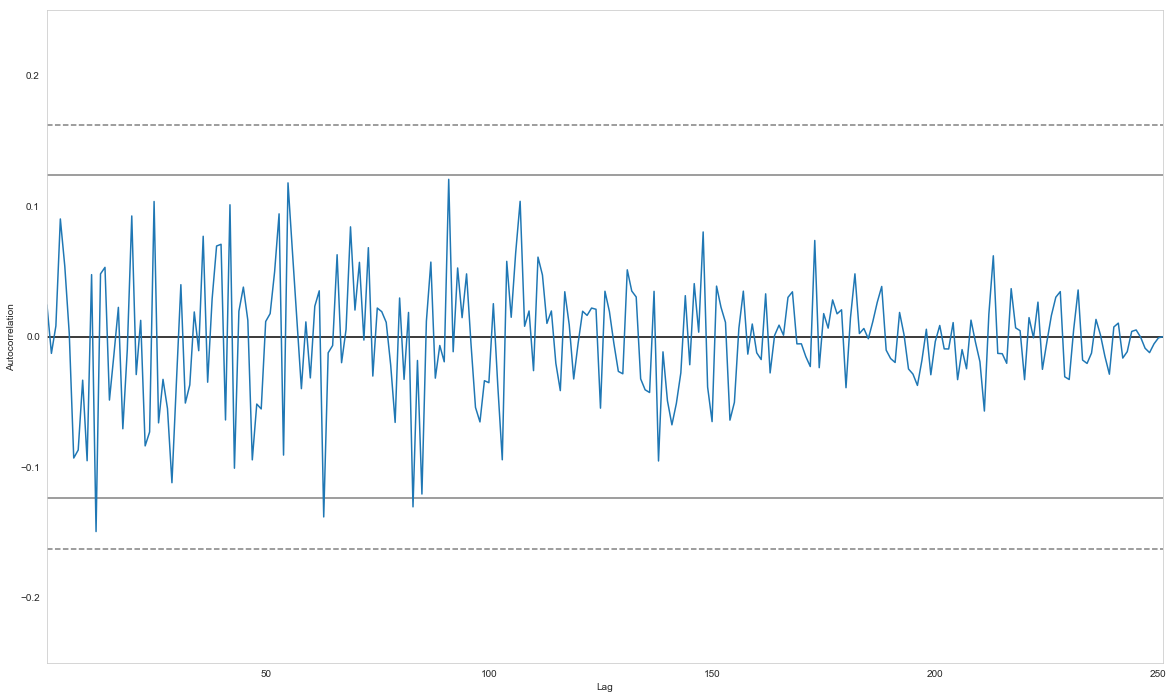

In [40]:
plt.figure(figsize=(20, 12))
pd.plotting.autocorrelation_plot(returns['CL'])
plt.ylim(-.25, .25);
